In [1]:
# Загружаем необходимые библиотеки 
# Библиотека для работы с функциями операционной системы
import os

# Даталоадер
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# Загрузка изображений 
from torchvision.datasets import ImageFolder
# Функции трансформации изображений, сохранения и компоновки 
import torchvision.transforms as tt
from torchvision.utils import save_image
from torchvision.utils import make_grid

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

# Общего применения 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.2)
import itertools
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output


# from torch.autograd import Variable
# import cv2

## 0. Настройки видеокарты 

In [2]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce RTX 3060
NVIDIA GeForce GTX 1050 Ti


In [3]:
#  Определяемся с устройством 
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

In [4]:
# Путь к данным 
TRAIN_DIR = '/home/master/dls/pix2pix/maps/maps/train/'
TEST_DIR   = '/home/master/dls/pix2pix/maps/maps/val/'

In [5]:
# Параметры для обработки изображения
# Размер изображения
image_size_full = 286
image_size = 256
# Размер батча
batch_size = 4 # 
test_batch_size = 8 # 
# Название эксперемента
exp_name = "pix2pix_foto2maps"
# Константы нормализации изображения 
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
# Создаем датасеты
train_ds = ImageFolder(TRAIN_DIR,  transform=tt.Compose([
    tt.Resize((image_size_full, 2*image_size_full)),
    tt.ToTensor(),
    tt.Normalize(*stats)])) # нормализация переводит знаячения  в [-1,1]
# Создаем датасеты
test_ds = ImageFolder(TEST_DIR,  transform=tt.Compose([
    tt.Resize((image_size_full, 2*image_size_full)),
    tt.ToTensor(),
    tt.Normalize(*stats)])) # 

In [7]:
train_ds

Dataset ImageFolder
    Number of datapoints: 1100
    Root location: /home/master/dls/pix2pix/maps/maps/train/
    StandardTransform
Transform: Compose(
               Resize(size=(286, 572), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [8]:
test_ds

Dataset ImageFolder
    Number of datapoints: 1100
    Root location: /home/master/dls/pix2pix/maps/maps/val/
    StandardTransform
Transform: Compose(
               Resize(size=(286, 572), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [9]:
train_ds[0][0].shape

torch.Size([3, 286, 572])

In [10]:
# Готовим даталоадер
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=test_batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

In [11]:
# Денормализация для вывода изображения, в генераторе на выходе гиперболтческий тангенс 
# Денормализация отобразит его выход [-1,1] в [0,1] для вывода
def denorm(img_tensors):
    return torch.clamp(img_tensors * stats[1][0] + stats[0][0],0,1)

In [12]:
# Функция вывода изображения
def show_images(images, nmax=4, title=''):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=2).permute(1, 2, 0))
# Вывод изображения батча 
def show_batch(dl, nmax=4):
    for images, _ in dl:
        print(images.shape)
        show_images(images, nmax)
        break

In [13]:
def load_state(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.train()

In [14]:
def save_state(file_name, model, optimizer):
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},   file_name)

In [15]:
def augmentation(images, target): 
    # Аугментация 
    
    # Отражения
    _f = np.random.randint(4) 
    if _f == 1:
        images = images
        target = target
    elif _f == 2:  
        images = torch.flip(images, dims=(3,))
        target = torch.flip(target, dims=(3,))
    elif _f == 3:
        images = torch.flip(images, dims=(2,))
        target = torch.flip(target, dims=(2,))
    else: 
        images = torch.transpose(images,2,3)
        target = torch.transpose(target,2,3)
    
    # кроп случайный
    _k1 = np.random.randint(image_size_full-image_size) 
    _k2 = np.random.randint(image_size_full-image_size) 
    images = images[:,:,_k1:_k1+image_size,_k2:_k2+image_size]
    target = target[:,:,_k1:_k1+image_size,_k2:_k2+image_size]
    
    return images, target

In [16]:
# Реализуем рандомный буфер 
class ImageBuffer():
    # Инициализация 
    def __init__(self, lens):
        # базовое количество карт
        self.lens = lens
        self.buffer = [None for i in range(lens)]
        self.idx = self.lens - 1
    
    # Поместить в буфер
    def push(self, images):
        self.idx = (self.idx + 1) % self.lens
        self.buffer[self.idx] = images
   
    # Извлечь из буфера
    def pop(self):
        if self.idx == 0:
            self.idx = self.lens - 1
            return self.buffer[0]
        else:
            self.idx = self.idx - 1
            return self.buffer[self.idx+1]
        
    # Получить случайный элемент из буфера, а на его место записать новый
    def random_update(self, images):
        _k = np.random.randint(self.lens)
        _res = self.buffer[_k]
        self.buffer[_k] = images
        return _res

torch.Size([4, 3, 286, 572])


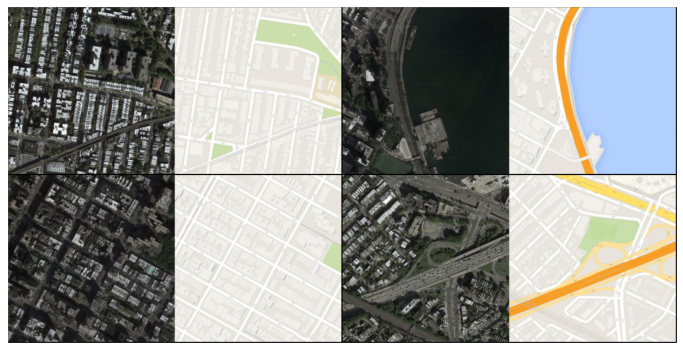

In [17]:
# Посмотрим содержимое датасета 
show_batch(train_dl)

In [18]:
def initialize_weights(m):
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight.data, 0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, 0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

In [19]:
# Блок Реснет 
class ResNetBlock(nn.Module):
    def __init__(self, channels):
        super(ResNetBlock, self).__init__()
        self.resnet  = nn.Sequential(
               
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, bias = True),
            nn.InstanceNorm2d(channels),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True), 
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, bias = True),
            nn.InstanceNorm2d(channels),

        )
        
    def forward(self, x):
        return x + self.resnet(x)

In [20]:
# Генератор
class GeneratorUnet(nn.Module):
    def __init__(self):
        super(GeneratorUnet, self).__init__()
        # базовое количество карт
        self.chanel = 64
        
        # Сеть энкодера  
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.chanel, kernel_size=4, stride=2, padding=1, bias = False),
            nn.LeakyReLU(0.2, inplace=True)  
        ) #256 -> 128 
        
        self.down2 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel, out_channels=self.chanel*2, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*2),
            nn.LeakyReLU(0.2, inplace=True)  
        ) #128 -> 64
        
        self.down3 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*2, out_channels=self.chanel*4, kernel_size=4, stride=2, padding=1, bias =True),
            nn.InstanceNorm2d(self.chanel*4),
            nn.LeakyReLU(0.2, inplace=True)  
        ) #64 -> 32
        
        self.down4 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*4, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.5)
        ) #32 -> 16
        
        self.down5 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*8, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.5)
        ) #16 -> 8
        
        
        self.down6 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*8, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.5)
        ) #8 -> 4
        
        self.down7 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*8, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.5)
        ) #4 -> 2
        
        self.down8 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*8, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1, bias = True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5)
        ) #4 -> 1
        
         # Сеть декодера 
        
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*8, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1 , bias = True),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5)
        )
        
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*16, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1,  bias = True),
            nn.InstanceNorm2d(self.chanel*8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*16, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*16, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*8),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5)
        )
        
        
        self.up5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*16, out_channels=self.chanel*4, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*4),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5)
        )
        
        self.up6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*8, out_channels=self.chanel*2, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*2),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5)
        )
        
        self.up7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*4, out_channels=self.chanel, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5)
        )
        
        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(in_channels=self.chanel*2, out_channels=3, kernel_size=4, stride=1, padding=1, bias = True),
            nn.Tanh()     
        )
        
    
    def forward(self, x):
        
        
        d1 = self.down1(x)  # 128х128
        d2 = self.down2(d1) # 64x64
        d3 = self.down3(d2) # 32х32
        d4 = self.down4(d3) # 16x16
        d5 = self.down5(d4) # 8x8
        d6 = self.down6(d5) # 4x4
        d7 = self.down7(d6) # 2x2
        d8 = self.down8(d7) # 1x1
        
        u1 = self.up1(d8)                         # 2x2
        u2 = self.up2(torch.cat([u1,d7],axis=1))  # 4x4
        u3 = self.up3(torch.cat([u2,d6],axis=1))  # 8x8
        u4 = self.up4(torch.cat([u3,d5],axis=1))  # 16x16
        u5 = self.up5(torch.cat([u4,d4],axis=1))  # 32x32
        u6 = self.up6(torch.cat([u5,d3],axis=1))  # 64x64
        u7 = self.up7(torch.cat([u6,d2],axis=1))  # 128x128 

        return self.final(torch.cat([u7,d1],axis=1))

In [21]:
# Генератор
class GeneratorResNet(nn.Module):
    def __init__(self):
        super(GeneratorResNet, self).__init__()
        # базовое количество карт
        self.chanel = 64
        
        # Сеть энкодера  
        
        self.input = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=3, out_channels=self.chanel, kernel_size=7, stride=1, padding=0, bias = True),
            nn.ReLU(inplace=True)  
        ) #256 -> 256
        
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel, out_channels=self.chanel*2, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*2),
            nn.ReLU(inplace=True) 
        ) #256 -> 128 
        
        self.down2 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*2, out_channels=self.chanel*4, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*4),
            nn.ReLU(inplace=True)    
        ) #128 -> 64
        
      
        self.resnet1 = ResNetBlock(self.chanel*4)
        self.resnet2 = ResNetBlock(self.chanel*4)
        self.resnet3 = ResNetBlock(self.chanel*4)
        self.resnet4 = ResNetBlock(self.chanel*4)
        self.resnet5 = ResNetBlock(self.chanel*4)
        self.resnet6 = ResNetBlock(self.chanel*4)
        self.resnet7 = ResNetBlock(self.chanel*4)
        self.resnet8 = ResNetBlock(self.chanel*4)
        self.resnet9 = ResNetBlock(self.chanel*4)
        
        
         # Сеть декодера 
        
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*4, out_channels=self.chanel*2, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*2),
            nn.ReLU(inplace=True)  
       
        ) # 64 -> 128
        
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*2, out_channels=self.chanel, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel),
            nn.ReLU(inplace=True)  
        ) # 128 -> 256
        
        
        
        self.out = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=self.chanel, out_channels=3, kernel_size=7, stride=1, padding=0, bias = True),  
            nn.Tanh()     
        )
        
    
    def forward(self, x):
        
        x = self.input(x)   # 256x256
        x = self.down1(x)   # 128x128
        x = self.down2(x)   # 64x64
      
        x = self.resnet1(x)
        x = self.resnet2(x)
        x = self.resnet3(x)
        x = self.resnet4(x)
        x = self.resnet5(x)
        x = self.resnet6(x)
        x = self.resnet7(x)
        x = self.resnet8(x)
        x = self.resnet9(x) # 64x64
        
        
        x = self.up1(x)  # 128x128
        x = self.up2(x)  # 256x256

        return self.out(x)

In [22]:
# Создаем и тестируем 
#generator = Generator()
generator = GeneratorUnet()
generator = generator.to(device)

In [23]:
generator.apply(initialize_weights)
None

In [24]:
train_ds[0][0][:,0:image_size_full,0:image_size_full].shape

torch.Size([3, 286, 286])

In [25]:
with torch.no_grad():
    print(generator(train_ds[0][0][:,0:image_size,0:image_size].unsqueeze(0).to(device)).shape)

torch.Size([1, 3, 256, 256])


In [26]:
from torchsummary import summary

In [27]:
# Параметры Генератора 
# print(summary(generator, input_size = (3,256,256), batch_size = -1,  device='cuda'))

In [28]:
# Дискриминатор 
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.chanel = 64
        self.discriminator = nn.Sequential(
            
            
            #  Входной с параметрами k=4, s=2, p=1 без нормализации 
            nn.Conv2d(6, self.chanel, kernel_size=4,  stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True), 
            
            # Три с параметрами k=4, s=2, p=1 с нормализацией 
            nn.Conv2d(self.chanel, self.chanel*2, kernel_size=4,  stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(self.chanel*2),
            nn.LeakyReLU(0.2, inplace=True), 

            nn.Conv2d(self.chanel*2, self.chanel*4, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(self.chanel*4),
            nn.LeakyReLU(0.2, inplace=True), 
            
            nn.Conv2d(self.chanel*4, self.chanel*8, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True), 
            
            
            #Один с параметрами k=4, s=1, p=1
            nn.Conv2d(self.chanel*8, self.chanel*8, kernel_size=4, stride=1, padding=1, bias=True),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True), 
            
            # Выход с параметрами k=1, s=1, p=1
            nn.Conv2d(self.chanel*8, 1, kernel_size=4,  stride=1, padding=1, bias=True),

        )
        
    def forward(self, x):
        return self.discriminator(x)

In [29]:
# Создаем и тестируем 
discriminator = Discriminator()
discriminator = discriminator.to(device)

In [30]:
discriminator.apply(initialize_weights)
None

In [31]:
with torch.no_grad():
    print(discriminator(torch.cat((train_ds[0][0][:,0:image_size,0:image_size].unsqueeze(0).to(device),
                          train_ds[0][0][:,0:image_size,image_size_full:image_size_full+image_size].unsqueeze(0).to(device)),1)).shape)

torch.Size([1, 1, 14, 14])


In [32]:
# Параметры Генератора 
#summary(discriminator,  input_size = (6,256,256), batch_size = -1,  device='cuda')

In [33]:
# Параметры оптимизаторов 
opt_g = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_d = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
scheduler_g = StepLR(opt_g, step_size=100, gamma=0.5)
scheduler_d = StepLR(opt_d, step_size=100, gamma=0.5)

In [34]:
# Тут накапливаем значения потерь генератора 
losses_g = []
losses_d = []
losses_d_real = []
losses_d_fake = []
losses_g_pix = []
losses_g_gan = []

In [35]:
epochs_start = 0

In [36]:
#load_state('/home/master/dls/Discriminator-epoch-2171_2b1.tsm', discriminator, opt_d)
#load_state('/home/master/dls/Generator-epoch-2171_2b1.tsm', generator, opt_g)

In [37]:
writer = SummaryWriter(comment=str(exp_name))

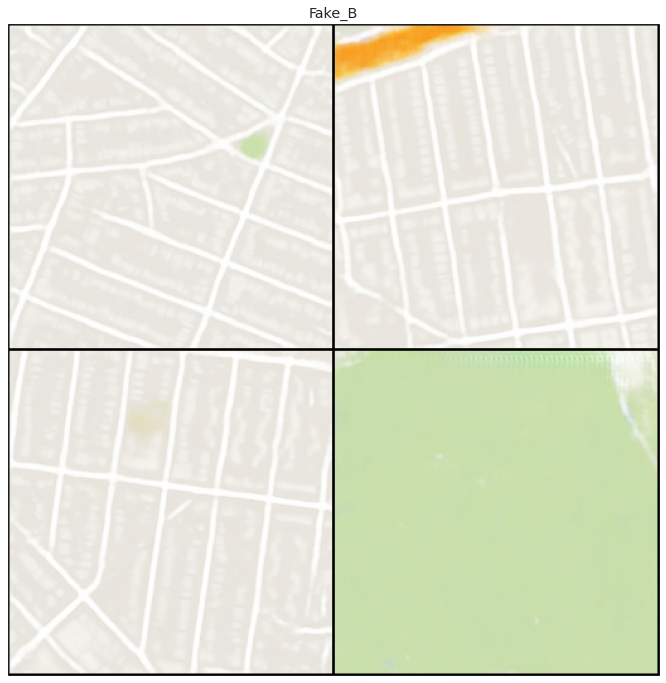

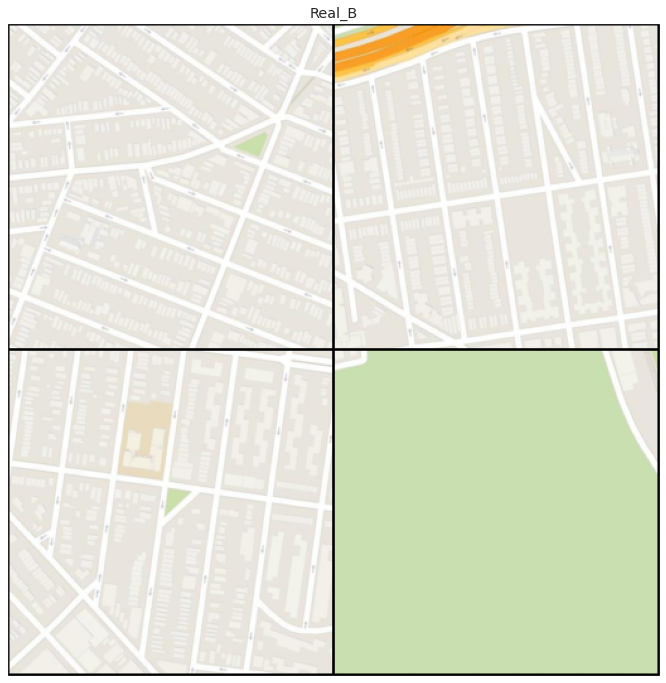

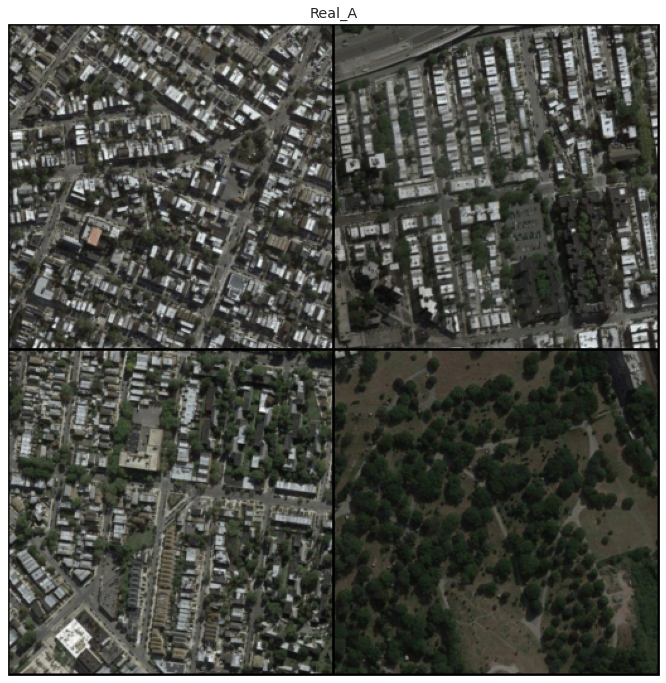

Эпоха: 1999 loss_d: 0.0007923 loss_d_real: 0.00042372 loss_d_fake: 0.00036858 loss_g: 4.297489 loss_g_pix: 3.298268 loss_g_gan: 0.999221
lr_g 0.0002 lr_d 0.0002


In [38]:
epochs = 2000
lambda_pix = 100
len_buf = 10
samples_per_epoch = 50
# чистим кеш 
torch.cuda.empty_cache()


test_batch  = next(iter(test_dl))
test_maps = test_batch[0][:,:,:,image_size_full:]
test_foto = test_batch[0][:,:,:,0:image_size_full]
test_foto, test_maps = augmentation(test_foto, test_maps)
test_maps = test_maps.to(device)
test_foto = test_foto.to(device)


# Инициализируем буфер 
generator.eval()
with torch.no_grad():
    ImgBuff = ImageBuffer(len_buf)
    for i in range(len_buf):
        _images = next(iter(train_dl))[0]
        maps = _images[:,:,:,image_size_full:]
        foto = _images[:,:,:,0:image_size_full]
        real_images, real_target = augmentation(foto,maps)
        fake_target  = generator(real_images.to(device)).to('cpu').detach()
        ImgBuff.push((real_images.detach().cpu(), real_target, fake_target))



# Бежим по эпохам
for epoch in range(epochs_start, epochs):
    # для накопления статистики по эпохе 
    loss_d_per_epoch = []
    loss_d_fake_per_epoch = []
    loss_d_real_per_epoch = []
    loss_g_per_epoch = []
    loss_g_pix_per_epoch = []
    loss_g_gan_per_epoch = []

        
    # Бежим батчами по датасету 
    for _ in tqdm(range(samples_per_epoch)):
        
        _images = next(iter(train_dl))[0]
        # Обучение генератора 
        
        generator.train()
        discriminator.train()
        
        # Зануляем градиенты 
        opt_g.zero_grad()
        
        # Готовим данные
        maps = _images[:,:,:,image_size_full:]
        foto = _images[:,:,:,0:image_size_full]
        real_images, real_target = augmentation(foto, maps)
        real_images = real_images.to(device) 
        real_target = real_target.to(device)
        fake_target = generator(real_images)
        fake_prediction = discriminator(torch.cat((real_images, fake_target),1))
        
        # Считаем лоссы генератора 
        loss_g_gan =  nn.MSELoss()(fake_prediction, torch.ones_like(fake_prediction).to(device))
        loss_g_pix =lambda_pix*nn.L1Loss()(real_target, fake_target)
        loss_g =  loss_g_gan  + loss_g_pix
        
        # Обратный проход
        loss_g.backward()
        
        # Делаем шаг генератора
        opt_g.step()
        
        # Обучение дискриминатора
        discriminator.train()
        
        # Зануляем градиенты 
        opt_d.zero_grad()
        
        # Готовим данные
        real_images, real_target, fake_target = ImgBuff.random_update((real_images.detach().cpu(), real_target.detach().cpu(), fake_target.detach().cpu()))
        real_images = real_images.to(device) 
        real_target = real_target.to(device)
        fake_target = fake_target.to(device)
        fake_prediction = discriminator(torch.cat((real_images, fake_target),1))
        real_prediction = discriminator(torch.cat((real_images, real_target),1))
        
        # Считаем лоссы
        loss_real = nn.MSELoss()(real_prediction, torch.ones_like(real_prediction).to(device))
        loss_fake = nn.MSELoss()(fake_prediction, torch.zeros_like(fake_prediction).to(device))
        loss_d = loss_real + loss_fake
        
        # Обратный проход
        loss_d.backward()
        
        # Делаем шаг дискриминатора  
        opt_d.step()
    
        # Статистика
        loss_d_per_epoch.append(loss_d.item())
        loss_d_fake_per_epoch.append(loss_fake.item())
        loss_d_real_per_epoch.append(loss_real.item())
        loss_g_per_epoch.append(loss_g.item())
        loss_g_pix_per_epoch.append(loss_g_pix.item())
        loss_g_gan_per_epoch.append(loss_g_gan.item())
        
    # Шаг шедуллера
    #scheduler_g.step()
    #scheduler_d.step()
    
    
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        test_fake = generator(test_foto).to('cpu')
    
    # Сохраняем историю
    losses_g.append(np.mean(loss_g_per_epoch))
    losses_d.append(np.mean(loss_d_per_epoch))
    losses_d_real.append(np.mean(loss_d_real_per_epoch))
    losses_d_fake.append(np.mean(loss_d_fake_per_epoch))
    losses_g_pix.append(np.mean(loss_g_pix_per_epoch))
    losses_g_gan.append(np.mean(loss_g_gan_per_epoch))
    
    # Выгружаем статистику в TensorBoard
    writer.add_scalar('loss_d', np.around(losses_d[-1],8), epoch)
    writer.add_scalar('loss_d_fake',np.around(losses_d_fake[-1],8), epoch)
    writer.add_scalar('loss_d_real', np.around(losses_d_real[-1],8), epoch)
    writer.add_scalar('loss_g', np.around(losses_g[-1],8), epoch)
    writer.add_scalar('loss_g_gan', np.around(losses_g_gan[-1],8), epoch)
    writer.add_scalar('loss_g_pix', np.around(losses_g_pix[-1],8), epoch)
    
    writer.add_image('Fake_B', make_grid(denorm(test_fake), nrow=2).permute(1, 2, 0), epoch, dataformats='HWC')
    writer.add_image('Real_A', make_grid(denorm(test_foto.cpu()), nrow=2).permute(1, 2, 0), epoch, dataformats='HWC')
    writer.add_image('Real_B', make_grid(denorm(test_maps.cpu()), nrow=2).permute(1, 2, 0), epoch, dataformats='HWC')
    writer.add_scalar('lr_g', opt_g.state_dict()['param_groups'][0]['lr'], epoch)
    writer.add_scalar('lr_d', opt_d.state_dict()['param_groups'][0]['lr'], epoch)
    writer.flush()
    
    # сохраняем результаты обучения 
    if epoch % 100 == 1:
        file_name = exp_name + '_d_epoch_' + str(epoch) +  '.tsm'
        save_state(file_name, discriminator, opt_d)
        file_name = exp_name + '_g_epoch_' + str(epoch) +  '.tsm'
        save_state(file_name, generator, opt_g)
    
    
    # Выводим картинки
    clear_output(wait=True)
    show_images(fake_target.cpu(), title = 'Fake_B')
    show_images(real_target.cpu(), title = 'Real_B')
    show_images(real_images.cpu(), title = 'Real_A')
    plt.show()
    
    # Печатаем статистику обучения по эпохе 
    print('Эпоха:', epoch, 
          'loss_d:', np.around(losses_d[-1],8),
          'loss_d_real:', np.around(losses_d_real[-1],8),
          'loss_d_fake:', np.around(losses_d_fake[-1],8),
          'loss_g:', np.around(losses_g[-1],6),
          'loss_g_pix:', np.around(losses_g_pix[-1],6),
          'loss_g_gan:', np.around(losses_g_gan[-1],6))
    print('lr_g', opt_g.state_dict()['param_groups'][0]['lr'],
          'lr_d', opt_d.state_dict()['param_groups'][0]['lr'])
    

In [39]:
file_name = exp_name + '_d_epoch_' + str(epoch) +  '.tsm'
save_state(file_name, discriminator, opt_d)
file_name = exp_name + '_g_epoch_' + str(epoch) +  '.tsm'
save_state(file_name, generator, opt_g)

In [40]:
opt_d.state_dict()['param_groups'][0]['lr']

0.0002

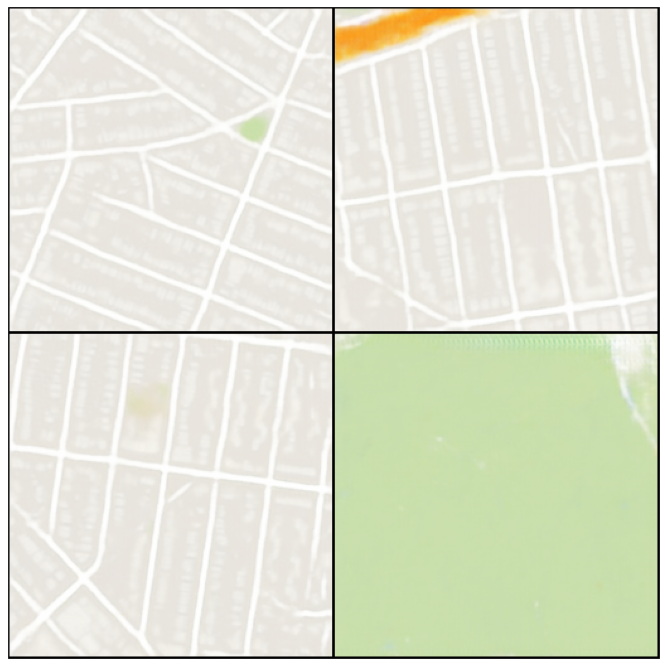

In [41]:
show_images(fake_target.cpu())

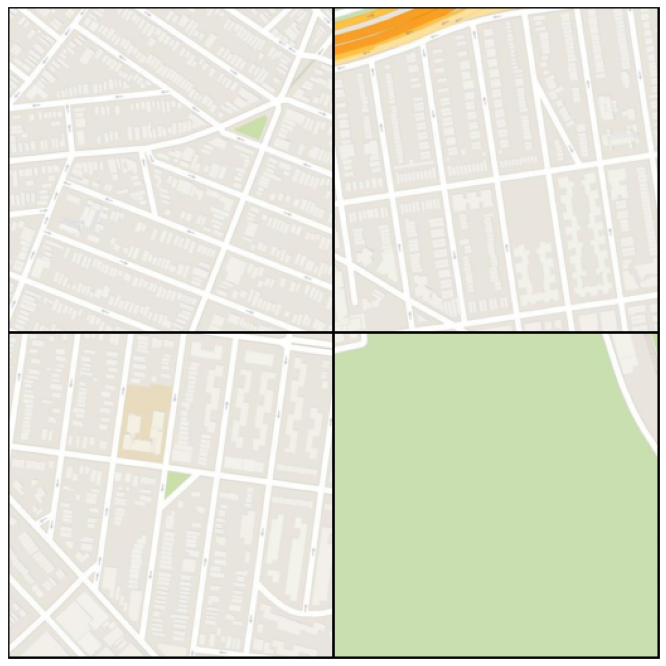

In [42]:
show_images(real_target.cpu())

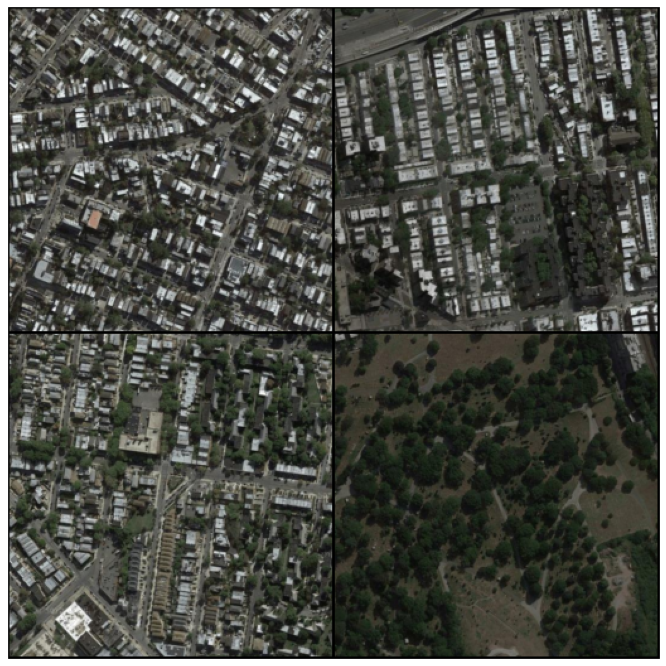

In [43]:
show_images(real_images.cpu())

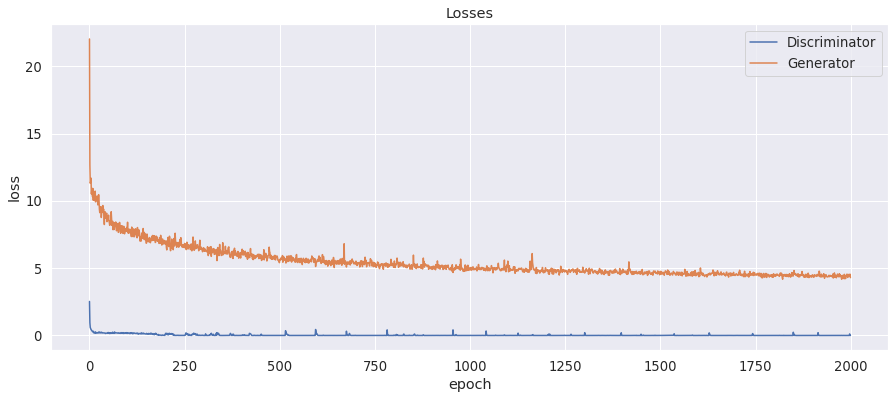

In [44]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

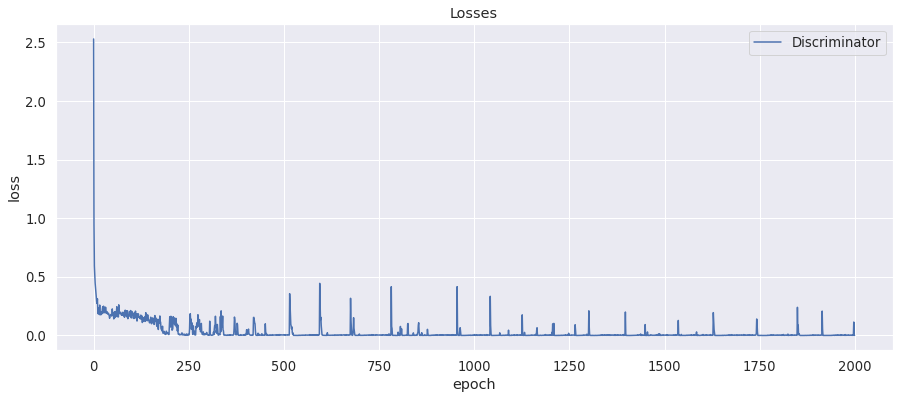

In [45]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

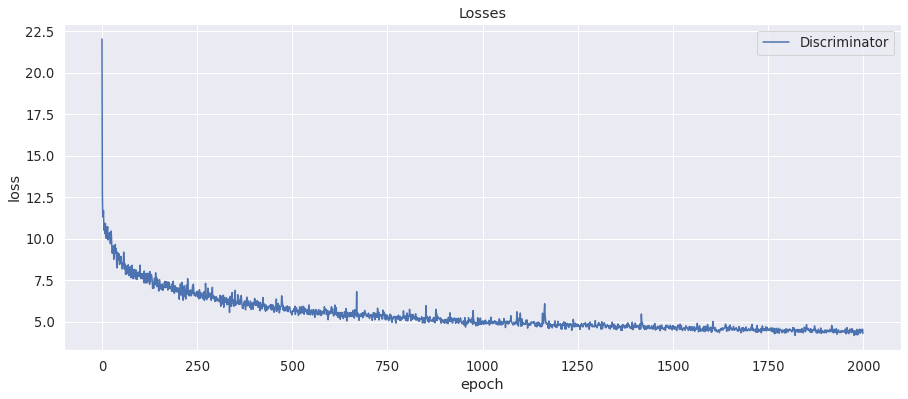

In [46]:
plt.figure(figsize=(15, 6))
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');